# Cell 1 — EXP-001 — Reducing Overfitting in CHIME Text Classification

This notebook runs a **controlled comparison** to improve generalization (reduce overfitting) for CHIME caption classification.

## Runs
- **Run A (Baseline)**: `bert-base-uncased`
- **Run B (Regularized BERT)**: `bert-base-uncased` + early stopping + weight decay (+ optional dropout)
- **Run C (Smaller model)**: `distilbert-base-uncased` + early stopping + weight decay

## Outputs
For each run, this notebook saves:
- `config.json`, `metrics.json`
- `confusion_matrix.png`, `learning_curves.png`
- optional `test_predictions.csv`

**Expected runtime:** depends on CPU/GPU. On CPU, BERT may take several minutes per run.

## Cell 2 — 0) Setup & dependency check
This notebook expects `torch`, `transformers`, `datasets`, `pandas`, `scikit-learn`, `matplotlib`, `seaborn`.

**Expected output:** a quick confirmation of versions and whether CUDA is available.

In [ ]:
# Cell 3
import os
import json
import time
import random
from dataclasses import asdict, dataclass
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())
print('device:', 'cuda' if torch.cuda.is_available() else 'cpu')

torch: 2.9.0+cu126
cuda available: True
device: cuda


## Cell 4 — 1) Experiment constants
Adjust these if needed. Keeping them centralized makes runs consistent.

In [ ]:
# Cell 5
# Dataset source (Option A)
HF_DATASET_NAME = 'ayusrjn/CHIME-recovery-framework'

# Models to compare
RUNS = [
    {
        'run_name': 'A_bert_baseline',
        'model_ckpt': 'bert-base-uncased',
        'use_early_stopping': False,
        'weight_decay': 0.0,
        'dropout': None,
    },
    {
        'run_name': 'B_bert_regularized',
        'model_ckpt': 'bert-base-uncased',
        'use_early_stopping': True,
        'weight_decay': 0.01,
        # Optional: increase dropout slightly to fight overfitting
        'dropout': 0.2,
    },
    {
        'run_name': 'C_distilbert_regularized',
        'model_ckpt': 'distilbert-base-uncased',
        'use_early_stopping': True,
        'weight_decay': 0.01,
        'dropout': None,
    },
]

# Reproducibility controls (kept lightweight)
SEED = 42
MAX_LENGTH = 128
TEST_SIZE = 0.10
VAL_SIZE = 0.10

# Training knobs (CPU-friendly defaults)
EPOCHS = 5
BATCH_SIZE = 8
LR = 2e-5

# Output folder
BASE_OUTPUT_DIR = os.path.join('ml_experiments_anish', 'experiment1_chime_text_overfitting', 'runs')
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print('Seed set to:', SEED)
print('Outputs will be saved under:', BASE_OUTPUT_DIR)

Seed set to: 42
Outputs will be saved under: ml_experiments_anish/experiment1_chime_text_overfitting/runs


In [ ]:
# Cell 6
import os
import sys
import platform
from pathlib import Path

print('=== Runtime filesystem diagnostic ===')
print('Platform:', platform.platform())
print('Python:', sys.version.split()[0])
print('CWD:', os.getcwd())
print('BASE_OUTPUT_DIR (as set):', BASE_OUTPUT_DIR)
print('BASE_OUTPUT_DIR (absolute):', str(Path(BASE_OUTPUT_DIR).resolve()))

# If you are using a Colab kernel, files are being written to the Colab VM filesystem,
# not your local VS Code workspace. This cell helps you confirm where artifacts live.
in_colab = 'google.colab' in sys.modules
print('Detected Colab kernel:', in_colab)

try:
    p = Path(BASE_OUTPUT_DIR)
    p.mkdir(parents=True, exist_ok=True)
    entries = sorted([x.name for x in p.iterdir()])
    print(f'Entries in BASE_OUTPUT_DIR ({len(entries)}):', entries[:50])
except Exception as e:
    print('Could not list BASE_OUTPUT_DIR due to:', repr(e))

# Write a tiny probe file so you can confirm persistence in the active kernel filesystem.
try:
    probe = Path(BASE_OUTPUT_DIR) / '_write_probe.txt'
    probe.write_text('ok\n', encoding='utf-8')
    print('Wrote probe file:', str(probe))
except Exception as e:
    print('Could not write probe file due to:', repr(e))

print('Tip: if you want artifacts to persist outside the Colab VM, set BASE_OUTPUT_DIR to a Google Drive path (after mounting Drive).')

=== Runtime filesystem diagnostic ===
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python: 3.12.12
CWD: /content
BASE_OUTPUT_DIR (as set): ml_experiments_anish/experiment1_chime_text_overfitting/runs
BASE_OUTPUT_DIR (absolute): /content/ml_experiments_anish/experiment1_chime_text_overfitting/runs
Detected Colab kernel: True
Entries in BASE_OUTPUT_DIR (27): ['2026-01-02_134810_A_bert_baseline_seed42', '2026-01-02_134936_B_bert_regularized_seed42', '2026-01-02_135102_C_distilbert_regularized_seed42', '2026-01-02_135544_S_bert_do0_wd0_lr1e-05_seed13', '2026-01-02_135710_S_bert_do0_wd0_lr1e-05_seed42', '2026-01-02_135841_S_bert_do0_wd0_lr1e-05_seed123', '2026-01-02_140003_S_bert_do0_wd0_lr2e-05_seed13', '2026-01-02_140128_S_bert_do0_wd0_lr2e-05_seed42', '2026-01-02_140252_S_bert_do0_wd0_lr2e-05_seed123', '2026-01-02_140401_S_bert_do0_wd0p001_lr1e-05_seed13', '2026-01-02_140518_S_bert_do0_wd0p001_lr1e-05_seed42', '2026-01-02_140640_S_bert_do0_wd0p001_lr1e-05_seed123', '2026-01-02_140807_S

In [ ]:
# Cell 7
import shutil
from pathlib import Path

print('=== Disk usage (Colab VM) ===')
for p in ['/', '/content', str(Path(BASE_OUTPUT_DIR).resolve())]:
    try:
        du = shutil.disk_usage(p)
        free_gb = du.free / (1024**3)
        total_gb = du.total / (1024**3)
        used_gb = du.used / (1024**3)
        print(f'{p:>30}  free={free_gb:6.2f} GB  used={used_gb:6.2f} GB  total={total_gb:6.2f} GB')
    except Exception as e:
        print(f'{p:>30}  (error: {e!r})')

# ---- Optional cleanup helpers ----
# When the Colab VM runs out of space, you can delete old run folders and/or HF caches.
# This does NOT affect your local Windows repo unless you explicitly copy things back.

DO_CLEANUP = True  # set True to actually delete files
KEEP_BASELINE_RUNS = False  # set False to also delete A/B/C runs
KEEP_LAST_N_RUN_FOLDERS = 0  # keep the newest N run folders (after keeping baseline)
DELETE_SWEEP_RUNS_FIRST = True  # delete only sweep runs (S_bert_*) before deleting other runs
DELETE_HF_CACHE = False  # last resort: redownloads models/datasets later

# Common HF cache locations on Colab
HF_CACHE_DIRS = [
    Path.home() / '.cache' / 'huggingface' / 'hub',
    Path.home() / '.cache' / 'huggingface' / 'datasets',
    Path('/root/.cache/huggingface/hub'),
    Path('/root/.cache/huggingface/datasets'),
    Path('/root/.cache/torch'),
    Path.home() / '.cache' / 'torch',
]

def _is_run_dir(p: Path) -> bool:
    if not p.is_dir():
        return False
    name = p.name
    return ('_seed' in name) and (name[0].isdigit())

def _is_sweep_run_dir(p: Path) -> bool:
    return _is_run_dir(p) and ('_S_' in p.name or 'S_bert_' in p.name)

def _is_baseline_run_dir(p: Path) -> bool:
    if not _is_run_dir(p):
        return False
    return (
        ('A_bert_baseline' in p.name)
        or ('B_bert_regularized' in p.name)
        or ('C_distilbert_regularized' in p.name)
    )

def _delete_path(p: Path):
    if p.is_dir():
        shutil.rmtree(p, ignore_errors=True)
    elif p.exists():
        try:
            p.unlink()
        except Exception:
            pass

def cleanup_disk():
    base = Path(BASE_OUTPUT_DIR)
    if not base.exists():
        print('BASE_OUTPUT_DIR does not exist:', str(base))
        return

    # Collect run folders and sort oldest->newest by name (timestamp prefix sorts lexicographically)
    run_dirs = sorted([p for p in base.iterdir() if _is_run_dir(p)], key=lambda p: p.name)
    if not run_dirs:
        print('No run folders found under:', str(base))
        return

    kept = set()
    if KEEP_BASELINE_RUNS:
        for p in run_dirs:
            if _is_baseline_run_dir(p):
                kept.add(p)

    # Optionally delete sweep runs first (usually the bulk)
    deleted = []
    if DELETE_SWEEP_RUNS_FIRST:
        for p in list(run_dirs):
            if p in kept:
                continue
            if _is_sweep_run_dir(p):
                deleted.append(p)
                _delete_path(p)

        # Refresh list after deletions
        run_dirs = sorted([p for p in base.iterdir() if _is_run_dir(p)], key=lambda p: p.name)

    # Keep newest N (plus kept baselines)
    remaining = [p for p in run_dirs if p not in kept]
    to_keep_newest = set(remaining[-KEEP_LAST_N_RUN_FOLDERS:]) if KEEP_LAST_N_RUN_FOLDERS else set()
    for p in remaining:
        if p in to_keep_newest:
            continue
        deleted.append(p)
        _delete_path(p)

    print(f'Deleted {len(deleted)} run folders.')
    if deleted:
        print('Examples deleted:', [d.name for d in deleted[:5]])
    print('Kept baseline runs:', [p.name for p in sorted(kept, key=lambda x: x.name)])
    print('Kept newest runs:', [p.name for p in sorted(to_keep_newest, key=lambda x: x.name)])

    if DELETE_HF_CACHE:
        cache_deleted = 0
        for d in HF_CACHE_DIRS:
            if d.exists():
                _delete_path(d)
                cache_deleted += 1
        print(f'Deleted {cache_deleted} HF/torch cache dirs (if existed).')

    # Print disk usage after cleanup
    du2 = shutil.disk_usage('/')
    print(f"Free space after cleanup: {du2.free / (1024**3):.2f} GB")

if DO_CLEANUP:
    cleanup_disk()
else:
    print('Cleanup is disabled. Set DO_CLEANUP=True to delete old artifacts.')

=== Disk usage (Colab VM) ===
                             /  free= 73.21 GB  used= 39.41 GB  total=112.64 GB
                      /content  free= 73.21 GB  used= 39.41 GB  total=112.64 GB
/content/ml_experiments_anish/experiment1_chime_text_overfitting/runs  free= 73.21 GB  used= 39.41 GB  total=112.64 GB
No run folders found under: ml_experiments_anish/experiment1_chime_text_overfitting/runs


## Cell 8 — 2) Load dataset from Hugging Face
We will load the dataset referenced by the project experiments README.

**Expected output:** dataset columns, row count, and label distribution.

In [ ]:
# Cell 9
ds = load_dataset(HF_DATASET_NAME)
print(ds)

# Convert to a single pandas DataFrame for consistent splitting
# Handles cases where dataset has a single split or multiple splits.
if hasattr(ds, 'keys') and len(ds.keys()) > 0:
    # Prefer a 'train' split if it exists, otherwise take the first split
    split_name = 'train' if 'train' in ds else list(ds.keys())[0]
    base = ds[split_name]
else:
    base = ds

df = base.to_pandas()
print('Rows:', len(df))
print('Columns:', list(df.columns))
display(df.head(3))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

version1.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/504 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['CAPTIONS', 'labels'],
        num_rows: 504
    })
})
Rows: 504
Columns: ['CAPTIONS', 'labels']


,CAPTIONS,labels
0,Went to my first peer support group today. It ...,Connectedness
1,Just finished painting again after years! It f...,Identity
2,My therapist helped me set some realistic goal...,Hope


## Cell 10 — 3) Normalize columns (text + label)
The legacy EXP-001 notebook used `CAPTIONS` and `labels`. Here we detect likely column names and standardize them to:
- `text`
- `label`

**Expected output:** confirmation of chosen columns + label distribution.

Using text column: CAPTIONS
Using label column: labels
Rows after cleanup: 504


,count
label,
Meaning,112
Empowerment,109
Identity,106
Hope,98
Connectedness,79


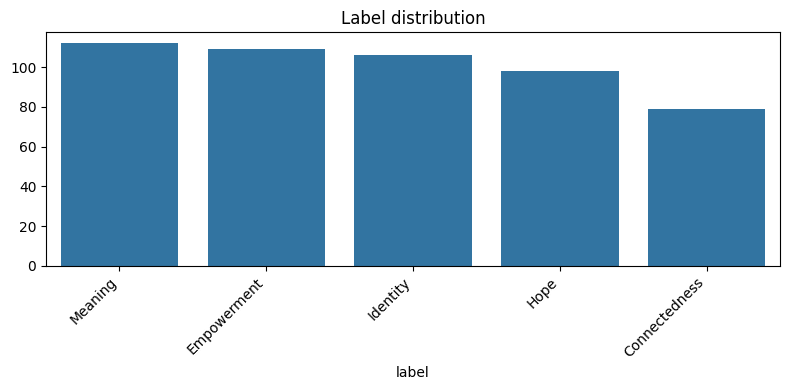

In [ ]:
# Cell 11
def pick_first_existing(columns, candidates):
    for c in candidates:
        if c in columns:
            return c
    return None

text_col = pick_first_existing(df.columns, ['CAPTIONS', 'caption', 'captions', 'text', 'sentence', 'content'])
label_col = pick_first_existing(df.columns, ['labels', 'label', 'category', 'class', 'target'])

if text_col is None or label_col is None:
    raise ValueError(
        f'Could not infer text/label columns. Found columns={list(df.columns)}. '
        'Please update the candidates list.'
    )

df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'})
df['text'] = df['text'].astype(str).fillna('')
df['label'] = df['label'].astype(str)

# Drop empty texts (if any)
df = df[df['text'].str.strip().astype(bool)].reset_index(drop=True)

print('Using text column:', text_col)
print('Using label column:', label_col)
print('Rows after cleanup:', len(df))

label_counts = df['label'].value_counts()
display(label_counts)

plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Cell 12 — 4) Train/Val/Test split
We create consistent splits with stratification.

**Expected output:** split sizes and per-split label distribution sanity checks.

In [ ]:
# Cell 13
# First split off test
train_val_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df['label'],
)

# Then split train/val
val_relative = VAL_SIZE / (1.0 - TEST_SIZE)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_relative,
    random_state=SEED,
    stratify=train_val_df['label'],
)

print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

def show_split_stats(name, split_df):
    vc = split_df['label'].value_counts(normalize=True).sort_index()
    print(f'-- {name} label distribution (fraction) --')
    print(vc)

show_split_stats('train', train_df)
show_split_stats('val', val_df)
show_split_stats('test', test_df)

Train: 402 Val: 51 Test: 51
-- train label distribution (fraction) --
label
Connectedness    0.156716
Empowerment      0.216418
Hope             0.194030
Identity         0.208955
Meaning          0.223881
Name: proportion, dtype: float64
-- val label distribution (fraction) --
label
Connectedness    0.156863
Empowerment      0.215686
Hope             0.196078
Identity         0.215686
Meaning          0.215686
Name: proportion, dtype: float64
-- test label distribution (fraction) --
label
Connectedness    0.156863
Empowerment      0.215686
Hope             0.196078
Identity         0.215686
Meaning          0.215686
Name: proportion, dtype: float64


## Cell 14 — 5) Label mapping
We create a stable `label2id` and `id2label`.

**Expected output:** the mapping table.

In [ ]:
# Cell 15
labels_sorted = sorted(df['label'].unique().tolist())
label2id = {lbl: i for i, lbl in enumerate(labels_sorted)}
id2label = {i: lbl for lbl, i in label2id.items()}

print('Labels:', labels_sorted)
print('label2id:', label2id)

def encode_labels(split_df):
    out = split_df.copy()
    out['label_id'] = out['label'].map(label2id)
    if out['label_id'].isna().any():
        raise ValueError('Found unknown labels during encoding.')
    out['label_id'] = out['label_id'].astype(int)
    return out

train_df = encode_labels(train_df)
val_df = encode_labels(val_df)
test_df = encode_labels(test_df)

display(pd.DataFrame({'label': labels_sorted, 'id': [label2id[x] for x in labels_sorted]}))

Labels: ['Connectedness', 'Empowerment', 'Hope', 'Identity', 'Meaning']
label2id: {'Connectedness': 0, 'Empowerment': 1, 'Hope': 2, 'Identity': 3, 'Meaning': 4}


,label,id
0,Connectedness,0
1,Empowerment,1
2,Hope,2
3,Identity,3
4,Meaning,4


## Cell 16 — 6) Metrics + plotting helpers
**Expected output:** none (helpers only).

In [ ]:
# Cell 17
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    weighted_f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
    }

def save_json(path, obj):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def plot_and_save_confusion_matrix(y_true, y_pred, labels, out_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title('Confusion Matrix (Test)')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

def plot_and_save_learning_curves(trainer_state_log_history, out_path):
    steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []

    for row in trainer_state_log_history:
        if 'loss' in row and 'eval_loss' not in row:
            if 'step' in row:
                steps.append(row['step'])
                train_loss.append(row['loss'])
        if 'eval_loss' in row:
            if 'step' in row:
                eval_steps.append(row['step'])
                eval_loss.append(row['eval_loss'])

    plt.figure(figsize=(8, 5))
    if steps:
        plt.plot(steps, train_loss, label='train_loss')
    if eval_steps:
        plt.plot(eval_steps, eval_loss, label='eval_loss')
    plt.title('Learning Curves')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

## Cell 18 — 7) Tokenization + dataset preparation helper
We tokenize separately per model (because tokenizers differ across model families).

**Expected output:** none (helpers only).

In [ ]:
# Cell 19
def df_to_hf_dataset(split_df):
    from datasets import Dataset
    return Dataset.from_pandas(
        split_df[['text', 'label_id']].rename(columns={'label_id': 'labels'}).reset_index(drop=True)
    )

train_hf = df_to_hf_dataset(train_df)
val_hf = df_to_hf_dataset(val_df)
test_hf = df_to_hf_dataset(test_df)

def make_tokenized_datasets(model_ckpt: str):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

    def tokenize_batch(batch):
        return tokenizer(batch['text'], truncation=True, max_length=MAX_LENGTH)

    train_tok = train_hf.map(tokenize_batch, batched=True)
    val_tok = val_hf.map(tokenize_batch, batched=True)
    test_tok = test_hf.map(tokenize_batch, batched=True)

    cols_to_keep = ['input_ids', 'attention_mask', 'labels']
    train_tok = train_tok.remove_columns([c for c in train_tok.column_names if c not in cols_to_keep])
    val_tok = val_tok.remove_columns([c for c in val_tok.column_names if c not in cols_to_keep])
    test_tok = test_tok.remove_columns([c for c in test_tok.column_names if c not in cols_to_keep])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return tokenizer, data_collator, train_tok, val_tok, test_tok

## Cell 20 — 8) Training helper (Trainer)
This function runs a training configuration and saves artifacts into a per-run folder.

**Expected output:** training logs, evaluation metrics, and saved plots/files under `runs/`.

In [ ]:
# Cell 21
import inspect
import shutil
from dataclasses import dataclass
from datetime import datetime

@dataclass
class RunResult:
    run_name: str
    model_ckpt: str
    output_dir: str
    eval_metrics: dict
    test_metrics: dict

def run_training(run_cfg: dict) -> RunResult:
    run_name = run_cfg["run_name"]
    model_ckpt = run_cfg["model_ckpt"]

    timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    out_dir = os.path.join(BASE_OUTPUT_DIR, f"{timestamp}_{run_name}_seed{SEED}")
    os.makedirs(out_dir, exist_ok=True)

    tokenizer, data_collator, train_tok, val_tok, test_tok = make_tokenized_datasets(model_ckpt)

    config = AutoConfig.from_pretrained(
        model_ckpt,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id,
    )

    if run_cfg.get("dropout") is not None:
        d = float(run_cfg["dropout"])
        for attr in (
            "hidden_dropout_prob",
            "attention_probs_dropout_prob",
            "dropout",
            "attention_dropout",
            "classifier_dropout",
        ):
            if hasattr(config, attr):
                setattr(config, attr, d)

    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

    trainer_dir = os.path.join(out_dir, "trainer")
    os.makedirs(trainer_dir, exist_ok=True)

    save_strategy = str(run_cfg.get("save_strategy", "epoch"))

    ta_kwargs = dict(
        output_dir=trainer_dir,
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=float(run_cfg.get("weight_decay", 0.0)),
        save_strategy=save_strategy,
        load_best_model_at_end=False,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        logging_strategy="steps",
        logging_steps=10,
        save_total_limit=1,
        report_to=[],
        seed=SEED,
    )

    load_best = run_cfg.get("load_best_model_at_end", None)
    if load_best is None:
        load_best = bool(run_cfg.get("use_early_stopping", False)) and save_strategy != "no"
    ta_kwargs["load_best_model_at_end"] = bool(load_best)

    ta_sig = inspect.signature(TrainingArguments.__init__)
    if "eval_strategy" in ta_sig.parameters:
        ta_kwargs["eval_strategy"] = "epoch"
    else:
        ta_kwargs["evaluation_strategy"] = "epoch"

    if "save_only_model" in ta_sig.parameters:
        ta_kwargs["save_only_model"] = bool(run_cfg.get("save_only_model", True))
    if "save_safetensors" in ta_sig.parameters:
        ta_kwargs["save_safetensors"] = True

    args = TrainingArguments(**ta_kwargs)

    callbacks = []
    if run_cfg.get("use_early_stopping", False):
        callbacks.append(EarlyStoppingCallback(early_stopping_patience=2))

    trainer_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks,
    )
    trainer_sig = inspect.signature(Trainer.__init__)
    if "tokenizer" in trainer_sig.parameters:
        trainer_kwargs["tokenizer"] = tokenizer

    trainer = Trainer(**trainer_kwargs)

    t0 = time.time()
    _train_output = trainer.train()
    train_time = time.time() - t0

    eval_metrics = trainer.evaluate()

    test_pred = trainer.predict(test_tok)
    test_logits = test_pred.predictions
    test_labels = test_pred.label_ids
    test_preds = np.argmax(test_logits, axis=1)

    test_metrics = {
        "accuracy": float(accuracy_score(test_labels, test_preds)),
        "macro_f1": float(f1_score(test_labels, test_preds, average="macro")),
        "weighted_f1": float(f1_score(test_labels, test_preds, average="weighted")),
        "classification_report": classification_report(
            test_labels,
            test_preds,
            target_names=labels_sorted,
            output_dict=True,
        ),
    }

    run_info = {
        "run_name": run_name,
        "model_ckpt": model_ckpt,
        "seed": SEED,
        "max_length": MAX_LENGTH,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "weight_decay": float(run_cfg.get("weight_decay", 0.0)),
        "use_early_stopping": bool(run_cfg.get("use_early_stopping", False)),
        "dropout": run_cfg.get("dropout", None),
        "train_time_sec": float(train_time),
        "label2id": label2id,
    }
    save_json(os.path.join(out_dir, "config.json"), run_info)
    save_json(os.path.join(out_dir, "eval_metrics.json"), eval_metrics)
    save_json(os.path.join(out_dir, "test_metrics.json"), test_metrics)

    if bool(run_cfg.get("save_predictions", True)):
        pred_df = test_df[["text", "label", "label_id"]].copy()
        pred_df["pred_id"] = test_preds
        pred_df["pred_label"] = pred_df["pred_id"].map(id2label)
        pred_df.to_csv(os.path.join(out_dir, "test_predictions.csv"), index=False, encoding="utf-8")

    if bool(run_cfg.get("save_plots", True)):
        plot_and_save_confusion_matrix(
            test_labels, test_preds, labels_sorted, os.path.join(out_dir, "confusion_matrix.png")
        )
        plot_and_save_learning_curves(
            trainer.state.log_history, os.path.join(out_dir, "learning_curves.png")
        )

    if bool(run_cfg.get("save_final_model", True)):
        model_dir = os.path.join(out_dir, "model")
        trainer.save_model(model_dir)
        tokenizer.save_pretrained(model_dir)

    if bool(run_cfg.get("cleanup_trainer_dir", False)):
        try:
            shutil.rmtree(trainer_dir, ignore_errors=True)
        except Exception:
            pass

    cleaned_run_dir = False
    if bool(run_cfg.get("cleanup_run_dir", False)):
        try:
            shutil.rmtree(out_dir, ignore_errors=True)
            cleaned_run_dir = True
        except Exception:
            cleaned_run_dir = False

    if cleaned_run_dir:
        print("Sweep mode: deleted run folder:", out_dir)
    else:
        print("Saved run artifacts to:", out_dir)

    return RunResult(
        run_name=run_name,
        model_ckpt=model_ckpt,
        output_dir=out_dir,
        eval_metrics=eval_metrics,
        test_metrics=test_metrics,
    )

## Cell 22 — 9) Run all experiments
This will train and evaluate each run in `RUNS`.

**Expected output:** training logs per run + saved artifacts under `runs/`.

If your machine is slow/CPU-only, you can start by running only the baseline (Run A) by temporarily setting `RUNS = RUNS[:1]` in Cell 5.


Starting: A_bert_baseline Model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.532200,1.492474,0.372549,0.295912,0.281474
2,1.164500,1.088489,0.725490,0.739523,0.730957
3,0.797100,0.767235,0.803922,0.802641,0.802217
4,0.506100,0.555535,0.862745,0.865378,0.862201
5,0.384800,0.493364,0.882353,0.888571,0.882633


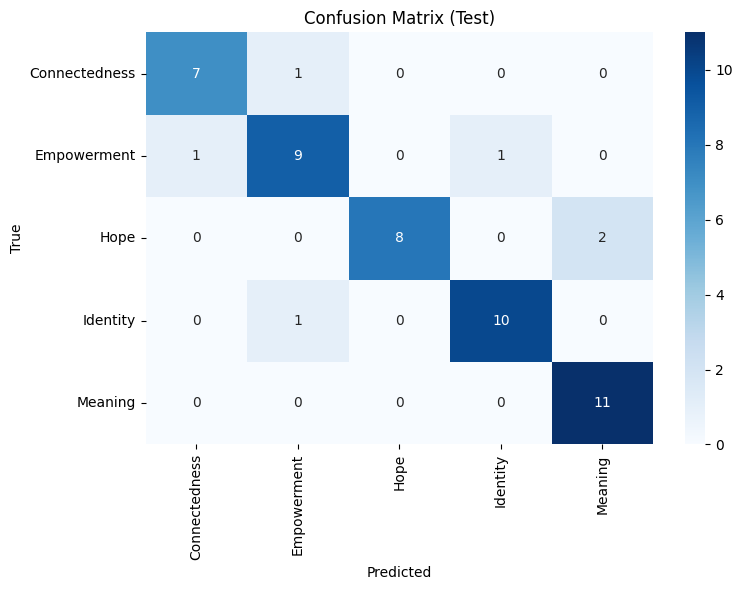

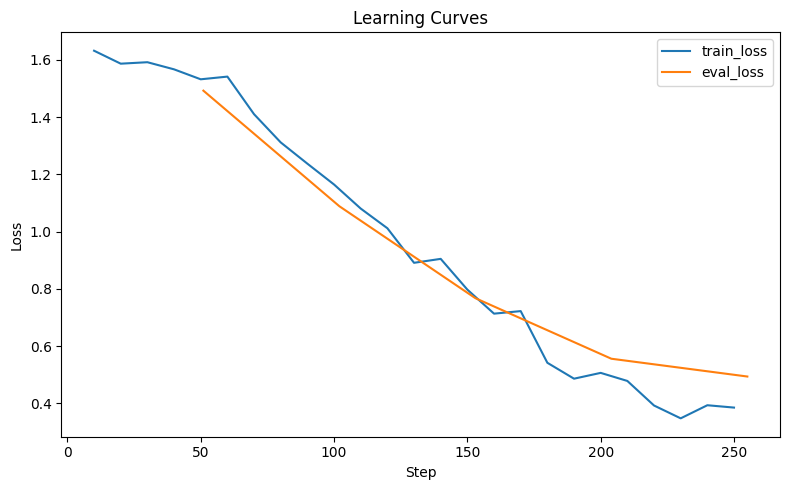

Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_134810_A_bert_baseline_seed42

Starting: B_bert_regularized Model: bert-base-uncased


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.478300,1.355870,0.509804,0.435948,0.461425
2,1.270400,1.191046,0.549020,0.507111,0.524009
3,1.001000,0.937164,0.725490,0.719429,0.724874
4,0.842000,0.808967,0.843137,0.846188,0.844573
5,0.698500,0.765035,0.843137,0.846188,0.844573


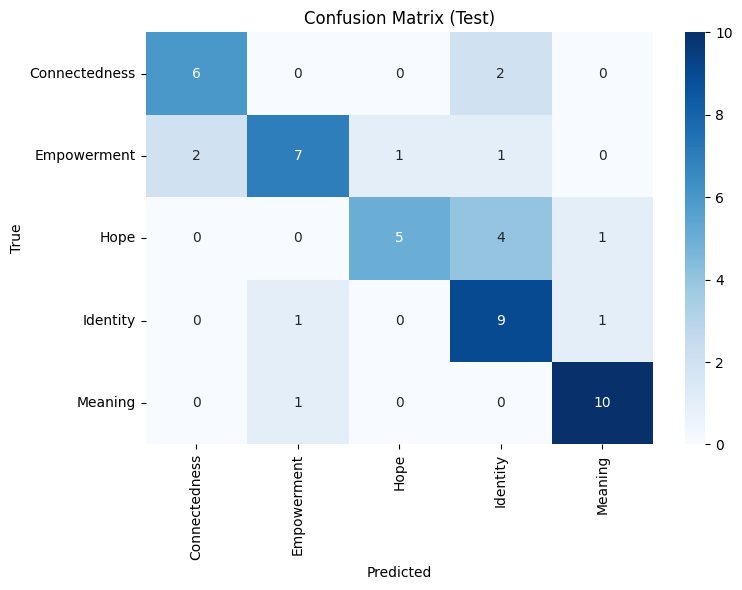

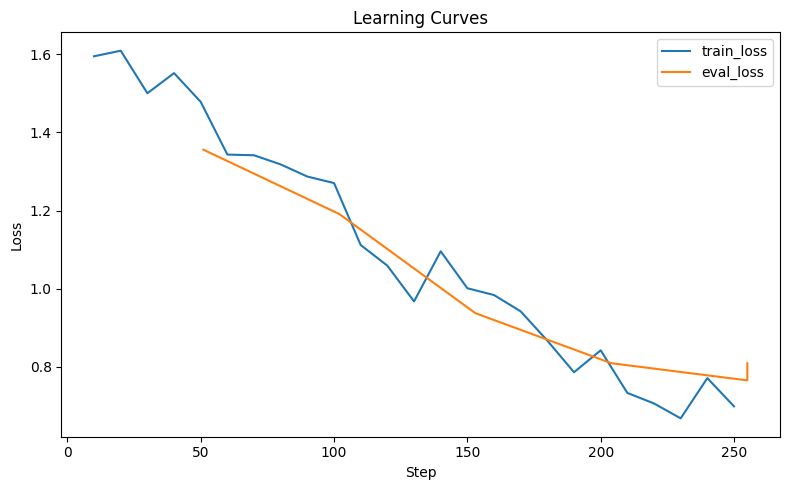

Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_134936_B_bert_regularized_seed42

Starting: C_distilbert_regularized Model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.437800,1.396146,0.647059,0.637037,0.625563
2,1.186100,1.099813,0.764706,0.763768,0.759946
3,0.788900,0.838352,0.784314,0.792352,0.785293
4,0.525400,0.675704,0.803922,0.814986,0.806242
5,0.421700,0.634403,0.843137,0.848347,0.843009


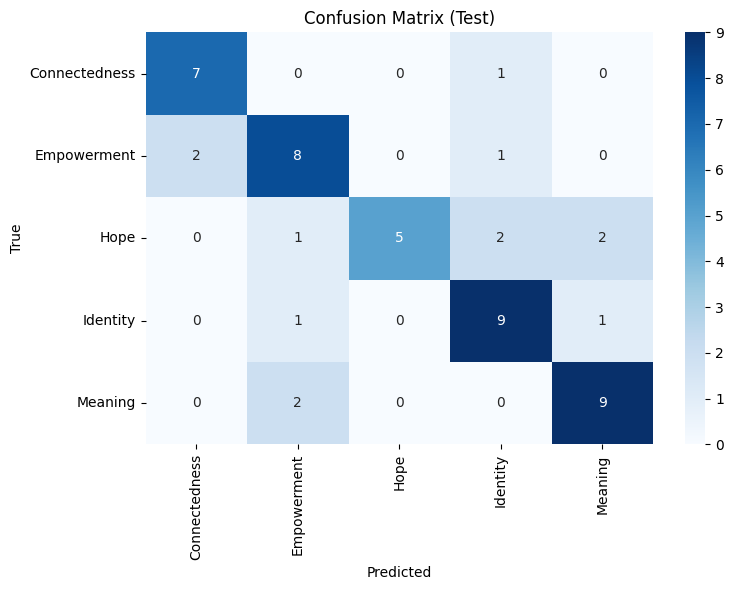

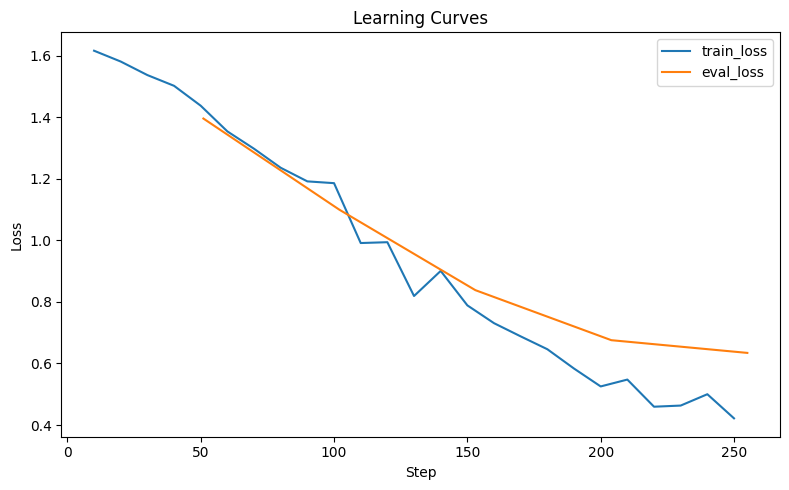

Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_135102_C_distilbert_regularized_seed42

Done. Completed runs: ['A_bert_baseline', 'B_bert_regularized', 'C_distilbert_regularized']


In [ ]:
# Cell 23
results = []
for cfg in RUNS:
    print('\n' + '='*90)
    print('Starting:', cfg['run_name'], 'Model:', cfg['model_ckpt'])
    print('='*90)
    res = run_training(cfg)
    results.append(res)

print('\nDone. Completed runs:', [r.run_name for r in results])

## Cell 24 — 10) Summarize results
We summarize eval/test metrics across runs in a table.

**Expected output:** a table comparing `accuracy`, `macro_f1`, and `weighted_f1`.

In [ ]:
# Cell 25
summary_rows = []
for r in results:
    row = {
        'run_name': r.run_name,
        'model': r.model_ckpt,
        'eval_accuracy': float(r.eval_metrics.get('eval_accuracy', np.nan)),
        'eval_macro_f1': float(r.eval_metrics.get('eval_macro_f1', np.nan)),
        'eval_weighted_f1': float(r.eval_metrics.get('eval_weighted_f1', np.nan)),
        'test_accuracy': float(r.test_metrics.get('accuracy', np.nan)),
        'test_macro_f1': float(r.test_metrics.get('macro_f1', np.nan)),
        'test_weighted_f1': float(r.test_metrics.get('weighted_f1', np.nan)),
        'output_dir': r.output_dir,
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values(by='test_macro_f1', ascending=False)
display(summary_df)

summary_path = os.path.join(BASE_OUTPUT_DIR, 'summary_latest.json')
save_json(summary_path, summary_rows)
print('Saved summary to:', summary_path)

,run_name,model,eval_accuracy,eval_macro_f1,eval_weighted_f1,test_accuracy,test_macro_f1,test_weighted_f1,output_dir
0,A_bert_baseline,bert-base-uncased,0.882353,0.888571,0.882633,0.882353,0.881566,0.881808,ml_experiments_anish/experiment1_chime_text_ov...
2,C_distilbert_regularized,distilbert-base-uncased,0.843137,0.848347,0.843009,0.745098,0.743691,0.740505,ml_experiments_anish/experiment1_chime_text_ov...
1,B_bert_regularized,bert-base-uncased,0.843137,0.846188,0.844573,0.725490,0.722246,0.722521,ml_experiments_anish/experiment1_chime_text_ov...


Saved summary to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/summary_latest.json


## Cell 26 — 11) Hyperparameter sweep runner
This runs a **small grid search** over a few values of `(dropout, weight_decay, learning_rate)` and repeats each setting across multiple seeds.

**Selection uses VALIDATION macro-F1** (not test), so we keep test as an unbiased final evaluation.

**Tip:** keep this small. Each trial is a full fine-tune run.

In [ ]:
# Cell 27
import itertools
import math
import shutil

# ----- Sweep hyperparameter grid -----
# Total trials = len(SWEEP_DROPOUT) * len(SWEEP_WEIGHT_DECAY) * len(SWEEP_LR) * len(SWEEP_SEEDS)
SWEEP_DROPOUT = [0.0, 0.1]
SWEEP_WEIGHT_DECAY = [0.0, 0.001]
SWEEP_LR = [1e-5, 2e-5]
SWEEP_SEEDS = [13, 42, 123]  # 3 seeds minimum for stability

MAX_TRIALS = 50  # safety guard

# Disk safety
SWEEP_DELETE_OLD_SWEEP_RUNS = True
SWEEP_MIN_FREE_GB = 1.0

# For sweeps, skip heavy artifacts per trial
SWEEP_SAVE_FINAL_MODEL = False
SWEEP_SAVE_PREDICTIONS = False
SWEEP_SAVE_PLOTS = False
SWEEP_CLEANUP_TRAINER_DIR = True
SWEEP_CLEANUP_RUN_DIR = True

def _disk_free_gb(path: str) -> float:
    du = shutil.disk_usage(path)
    return float(du.free) / (1024 ** 3)

def _delete_old_sweep_runs(base_dir: str) -> int:
    if not os.path.isdir(base_dir):
        return 0
    deleted = 0
    for name in os.listdir(base_dir):
        full = os.path.join(base_dir, name)
        if os.path.isdir(full) and '_S_' in name:
            shutil.rmtree(full, ignore_errors=True)
            deleted += 1
    return deleted

def _fmt_float(x) -> str:
    if x is None:
        return 'none'
    if isinstance(x, (int, np.integer)):
        return str(int(x))
    if math.isclose(float(x), 0.0):
        return '0'
    return f'{float(x):g}'.replace('.', 'p')

def _make_sweep_run_name(dropout, weight_decay, lr) -> str:
    return f"S_bert_do{_fmt_float(dropout)}_wd{_fmt_float(weight_decay)}_lr{_fmt_float(lr)}"

base_cfg = {
    'run_name': 'SWEEP',
    'model_ckpt': 'bert-base-uncased',
    'use_early_stopping': True,
    'weight_decay': 0.0,
    'dropout': None,
    'save_strategy': 'no',
    'load_best_model_at_end': False,
    'save_only_model': True,
    'save_final_model': SWEEP_SAVE_FINAL_MODEL,
    'save_predictions': SWEEP_SAVE_PREDICTIONS,
    'save_plots': SWEEP_SAVE_PLOTS,
    'cleanup_trainer_dir': SWEEP_CLEANUP_TRAINER_DIR,
    'cleanup_run_dir': SWEEP_CLEANUP_RUN_DIR,
}

grid = list(itertools.product(SWEEP_DROPOUT, SWEEP_WEIGHT_DECAY, SWEEP_LR, SWEEP_SEEDS))

try:
    free_gb = _disk_free_gb(BASE_OUTPUT_DIR)
    print(f'Free disk space: {free_gb:.2f} GB')
    if SWEEP_DELETE_OLD_SWEEP_RUNS and free_gb < SWEEP_MIN_FREE_GB:
        n_del = _delete_old_sweep_runs(BASE_OUTPUT_DIR)
        print(f'Deleted {n_del} old sweep folders. Free now: {_disk_free_gb(BASE_OUTPUT_DIR):.2f} GB')
except Exception as e:
    print('Disk check skipped:', repr(e))

print(f'Planned trials: {len(grid)}')
if len(grid) > MAX_TRIALS:
    raise ValueError(f'Sweep too large ({len(grid)} > {MAX_TRIALS}). Reduce grid or raise MAX_TRIALS.')

_orig_seed = SEED
_orig_lr = LR

sweep_rows = []
sweep_results = []

for dropout, weight_decay, lr, seed in grid:
    SEED = int(seed)
    LR = float(lr)
    set_seed(SEED)

    trial_cfg = dict(base_cfg)
    trial_cfg['run_name'] = _make_sweep_run_name(dropout, weight_decay, lr)
    trial_cfg['dropout'] = float(dropout)
    trial_cfg['weight_decay'] = float(weight_decay)

    print('\n' + '-'*90)
    print('Trial:', trial_cfg['run_name'], 'seed=', SEED)
    print('Params:', {'dropout': dropout, 'weight_decay': weight_decay, 'lr': lr})
    print('-'*90)

    rr = run_training(trial_cfg)
    sweep_results.append(rr)

    # --- CHANGED: record VALIDATION metrics for selection (not test) ---
    sweep_rows.append({
        'run_name': rr.run_name,
        'model': rr.model_ckpt,
        'dropout': float(dropout),
        'weight_decay': float(weight_decay),
        'lr': float(lr),
        'seed': int(seed),
        # Selection metrics (validation)
        'val_accuracy': float(rr.eval_metrics.get('eval_accuracy', np.nan)),
        'val_macro_f1': float(rr.eval_metrics.get('eval_macro_f1', np.nan)),
        'val_weighted_f1': float(rr.eval_metrics.get('eval_weighted_f1', np.nan)),
        # Also record test for reporting (but NOT used to pick best)
        'test_accuracy': float(rr.test_metrics.get('accuracy', np.nan)),
        'test_macro_f1': float(rr.test_metrics.get('macro_f1', np.nan)),
        'test_weighted_f1': float(rr.test_metrics.get('weighted_f1', np.nan)),
        'output_dir': None if SWEEP_CLEANUP_RUN_DIR else rr.output_dir,
    })

SEED = _orig_seed
LR = _orig_lr
set_seed(SEED)

sweep_df = pd.DataFrame(sweep_rows)
display(sweep_df.sort_values(by='val_macro_f1', ascending=False))

# --- Aggregate across seeds using VALIDATION macro-F1 ---
group_cols = ['dropout', 'weight_decay', 'lr']
agg_df = (
    sweep_df.groupby(group_cols)
    .agg(
        n_trials=('val_macro_f1', 'count'),
        mean_val_macro_f1=('val_macro_f1', 'mean'),
        std_val_macro_f1=('val_macro_f1', 'std'),
        mean_val_accuracy=('val_accuracy', 'mean'),
        # Also aggregate test for later reference
        mean_test_macro_f1=('test_macro_f1', 'mean'),
        std_test_macro_f1=('test_macro_f1', 'std'),
    )
    .sort_values(by=['mean_val_macro_f1', 'mean_val_accuracy'], ascending=False)
    .reset_index()
)
display(agg_df)

best = agg_df.iloc[0].to_dict() if len(agg_df) else None
print('Best setting by mean VALIDATION macro-F1:')
print(best)

Free disk space near output dir: 73.21 GB
Planned trials: 24

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr1e-05 seed= 13
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.445300,1.419597,0.549020,0.520357,0.535713
2,1.079400,1.153311,0.745098,0.735567,0.750193
3,0.771500,0.976553,0.803922,0.803292,0.799480
4,0.596700,0.876223,0.784314,0.790852,0.787683
5,0.545200,0.855856,0.803922,0.810238,0.808590


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153154_S_bert_do0_wd0_lr1e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr1e-05 seed= 42
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.500400,1.485905,0.392157,0.343937,0.354276
2,1.196200,1.187577,0.745098,0.760340,0.747310
3,0.900700,0.979959,0.764706,0.769588,0.762820
4,0.751500,0.863801,0.803922,0.806213,0.801698
5,0.599600,0.820701,0.843137,0.845005,0.840978


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153213_S_bert_do0_wd0_lr1e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr1e-05 seed= 123
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.395500,1.369299,0.490196,0.499739,0.484273
2,1.076400,1.243885,0.588235,0.611215,0.598276
3,0.842000,1.081109,0.705882,0.716602,0.707446
4,0.684300,0.962548,0.764706,0.770708,0.760077
5,0.622400,0.938336,0.764706,0.765101,0.755828


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153232_S_bert_do0_wd0_lr1e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr2e-05 seed= 13
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.273200,1.340725,0.392157,0.391940,0.383005
2,0.815900,0.990251,0.784314,0.791698,0.785357
3,0.442800,0.677576,0.803922,0.805891,0.800663
4,0.216700,0.511628,0.882353,0.885709,0.884127
5,0.135600,0.477056,0.882353,0.885709,0.884127


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153250_S_bert_do0_wd0_lr2e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr2e-05 seed= 42
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.373900,1.291775,0.725490,0.732337,0.723668
2,0.784200,0.739684,0.843137,0.848269,0.839170
3,0.294500,0.473955,0.901961,0.906723,0.901965
4,0.101500,0.380866,0.901961,0.906723,0.901965
5,0.056000,0.373090,0.862745,0.869668,0.863011


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153308_S_bert_do0_wd0_lr2e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0_lr2e-05 seed= 123
Params: {'dropout': 0.0, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.281100,1.310498,0.529412,0.527967,0.508441
2,0.772900,0.895376,0.725490,0.725238,0.719374
3,0.429200,0.586674,0.862745,0.856884,0.848927
4,0.187800,0.506479,0.823529,0.833333,0.824183
5,0.099200,0.466792,0.843137,0.850476,0.842670


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153327_S_bert_do0_wd0_lr2e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr1e-05 seed= 13
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.445300,1.419597,0.549020,0.520357,0.535713
2,1.079400,1.153311,0.745098,0.735567,0.750193
3,0.771500,0.976553,0.803922,0.803292,0.799480
4,0.596700,0.876223,0.784314,0.790852,0.787683
5,0.545200,0.855856,0.803922,0.810238,0.808590


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153345_S_bert_do0_wd0p001_lr1e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr1e-05 seed= 42
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.500400,1.485905,0.392157,0.343937,0.354276
2,1.196200,1.187577,0.745098,0.760340,0.747310
3,0.900700,0.979959,0.764706,0.769588,0.762820
4,0.751500,0.863801,0.803922,0.806213,0.801698
5,0.599600,0.820701,0.843137,0.845005,0.840978


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153403_S_bert_do0_wd0p001_lr1e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr1e-05 seed= 123
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.395500,1.369299,0.490196,0.499739,0.484273
2,1.076400,1.243885,0.588235,0.611215,0.598276
3,0.842000,1.081109,0.705882,0.716602,0.707446
4,0.684300,0.962548,0.764706,0.770708,0.760077
5,0.622400,0.938336,0.764706,0.765101,0.755828


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153421_S_bert_do0_wd0p001_lr1e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr2e-05 seed= 13
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.273200,1.340725,0.392157,0.391940,0.383005
2,0.815900,0.990251,0.784314,0.791698,0.785357
3,0.442800,0.677576,0.803922,0.805891,0.800663
4,0.216700,0.511628,0.882353,0.885709,0.884127
5,0.135600,0.477056,0.882353,0.885709,0.884127


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153439_S_bert_do0_wd0p001_lr2e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr2e-05 seed= 42
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.373900,1.291775,0.725490,0.732337,0.723668
2,0.784200,0.739684,0.843137,0.848269,0.839170
3,0.294500,0.473955,0.901961,0.906723,0.901965
4,0.101500,0.380866,0.901961,0.906723,0.901965
5,0.056000,0.373090,0.862745,0.869668,0.863011


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153457_S_bert_do0_wd0p001_lr2e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0_wd0p001_lr2e-05 seed= 123
Params: {'dropout': 0.0, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.281100,1.310498,0.529412,0.527967,0.508441
2,0.772900,0.895376,0.725490,0.725238,0.719374
3,0.429200,0.586674,0.862745,0.856884,0.848927
4,0.187800,0.506479,0.823529,0.833333,0.824183
5,0.099200,0.466792,0.843137,0.850476,0.842670


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153515_S_bert_do0_wd0p001_lr2e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr1e-05 seed= 13
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.484600,1.455249,0.411765,0.370786,0.379975
2,1.259800,1.271790,0.568627,0.594588,0.586637
3,1.103200,1.126079,0.686275,0.703545,0.695490
4,1.015900,1.065782,0.745098,0.750153,0.747198
5,0.953200,1.033129,0.803922,0.806818,0.806863


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153533_S_bert_do0p1_wd0_lr1e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr1e-05 seed= 42
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.568400,1.540070,0.274510,0.149160,0.160858
2,1.349000,1.332771,0.607843,0.621121,0.605885
3,1.193600,1.152870,0.784314,0.792762,0.783044
4,1.104600,1.072708,0.725490,0.718954,0.713251
5,0.977400,1.015031,0.823529,0.829691,0.825561


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153551_S_bert_do0p1_wd0_lr1e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr1e-05 seed= 123
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.471300,1.446675,0.470588,0.462222,0.459259
2,1.208600,1.303835,0.490196,0.475415,0.461420
3,1.053000,1.182020,0.647059,0.670473,0.652907
4,0.908200,1.090560,0.705882,0.717645,0.702517
5,0.885200,1.050270,0.745098,0.761765,0.750098


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153609_S_bert_do0p1_wd0_lr1e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr2e-05 seed= 13
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.379200,1.317531,0.509804,0.507766,0.491884
2,1.039700,1.026958,0.784314,0.791206,0.788216
3,0.706900,0.774550,0.784314,0.783381,0.782654
4,0.515200,0.667638,0.823529,0.824772,0.823332
5,0.421100,0.631634,0.823529,0.824772,0.823332


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153628_S_bert_do0p1_wd0_lr2e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr2e-05 seed= 42
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.532200,1.492474,0.372549,0.295912,0.281474
2,1.164500,1.088489,0.725490,0.739523,0.730957
3,0.797100,0.767235,0.803922,0.802641,0.802217
4,0.506100,0.555535,0.862745,0.865378,0.862201
5,0.384800,0.493364,0.882353,0.888571,0.882633


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153646_S_bert_do0p1_wd0_lr2e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0_lr2e-05 seed= 123
Params: {'dropout': 0.1, 'weight_decay': 0.0, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.414900,1.345424,0.666667,0.680111,0.668093
2,0.982200,0.986202,0.803922,0.810680,0.803649
3,0.635900,0.735106,0.823529,0.836077,0.827578
4,0.409600,0.618420,0.784314,0.795500,0.784621
5,0.339400,0.599797,0.784314,0.795500,0.784621


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153705_S_bert_do0p1_wd0_lr2e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr1e-05 seed= 13
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.484600,1.455249,0.411765,0.370786,0.379975
2,1.259800,1.271790,0.568627,0.594588,0.586637
3,1.103200,1.126079,0.686275,0.703545,0.695490
4,1.015900,1.065782,0.745098,0.750153,0.747198
5,0.953200,1.033129,0.803922,0.806818,0.806863


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153723_S_bert_do0p1_wd0p001_lr1e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr1e-05 seed= 42
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.568400,1.540070,0.274510,0.149160,0.160858
2,1.349000,1.332771,0.607843,0.621121,0.605885
3,1.193600,1.152870,0.784314,0.792762,0.783044
4,1.104600,1.072708,0.725490,0.718954,0.713251
5,0.977400,1.015031,0.823529,0.829691,0.825561


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153741_S_bert_do0p1_wd0p001_lr1e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr1e-05 seed= 123
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 1e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.471300,1.446675,0.470588,0.462222,0.459259
2,1.208600,1.303835,0.490196,0.475415,0.461420
3,1.053000,1.182020,0.647059,0.670473,0.652907
4,0.908200,1.090560,0.705882,0.717645,0.702517
5,0.885200,1.050270,0.745098,0.761765,0.750098


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153759_S_bert_do0p1_wd0p001_lr1e-05_seed123

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr2e-05 seed= 13
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.379200,1.317531,0.509804,0.507766,0.491884
2,1.039700,1.026958,0.784314,0.791206,0.788216
3,0.706900,0.774550,0.784314,0.783381,0.782654
4,0.515200,0.667638,0.823529,0.824772,0.823332
5,0.421100,0.631634,0.823529,0.824772,0.823332


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153818_S_bert_do0p1_wd0p001_lr2e-05_seed13

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr2e-05 seed= 42
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.532200,1.492474,0.372549,0.295912,0.281474
2,1.164500,1.088489,0.725490,0.739523,0.730957
3,0.797100,0.767235,0.803922,0.802641,0.802217
4,0.506100,0.555535,0.862745,0.865378,0.862201
5,0.384800,0.493364,0.882353,0.888571,0.882633


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153836_S_bert_do0p1_wd0p001_lr2e-05_seed42

------------------------------------------------------------------------------------------
Trial: S_bert_do0p1_wd0p001_lr2e-05 seed= 123
Params: {'dropout': 0.1, 'weight_decay': 0.001, 'lr': 2e-05}
------------------------------------------------------------------------------------------


Map:   0%|          | 0/402 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.414900,1.345424,0.666667,0.680111,0.668093
2,0.982200,0.986202,0.803922,0.810680,0.803649
3,0.635900,0.735106,0.823529,0.836077,0.827578
4,0.409600,0.618420,0.784314,0.795500,0.784621
5,0.339400,0.599797,0.784314,0.795500,0.784621


Saved run artifacts to: ml_experiments_anish/experiment1_chime_text_overfitting/runs/2026-01-02_153854_S_bert_do0p1_wd0p001_lr2e-05_seed123


,run_name,model,dropout,weight_decay,lr,seed,test_accuracy,test_macro_f1,test_weighted_f1,output_dir
2,S_bert_do0_wd0_lr1e-05,bert-base-uncased,0.0,0.000,0.00001,123,0.901961,0.900500,0.902228,None
23,S_bert_do0p1_wd0p001_lr2e-05,bert-base-uncased,0.1,0.001,0.00002,123,0.901961,0.900500,0.902228,None
17,S_bert_do0p1_wd0_lr2e-05,bert-base-uncased,0.1,0.000,0.00002,123,0.901961,0.900500,0.902228,None
8,S_bert_do0_wd0p001_lr1e-05,bert-base-uncased,0.0,0.001,0.00001,123,0.901961,0.900500,0.902228,None
7,S_bert_do0_wd0p001_lr1e-05,bert-base-uncased,0.0,0.001,0.00001,42,0.882353,0.881729,0.879373,None
1,S_bert_do0_wd0_lr1e-05,bert-base-uncased,0.0,0.000,0.00001,42,0.882353,0.881729,0.879373,None
22,S_bert_do0p1_wd0p001_lr2e-05,bert-base-uncased,0.1,0.001,0.00002,42,0.882353,0.881566,0.881808,None
16,S_bert_do0p1_wd0_lr2e-05,bert-base-uncased,0.1,0.000,0.00002,42,0.882353,0.881566,0.881808,None
5,S_bert_do0_wd0_lr2e-05,bert-base-uncased,0.0,0.000,0.00002,123,0.882353,0.878770,0.880075,None
11,S_bert_do0_wd0p001_lr2e-05,bert-base-uncased,0.0,0.001,0.00002,123,0.882353,0.878770,0.880075,None


,dropout,weight_decay,lr,n_trials,mean_test_accuracy,std_test_accuracy,mean_test_macro_f1,std_test_macro_f1,mean_test_weighted_f1,std_test_weighted_f1
0,0.1,0.000,0.00002,3,0.869281,0.040817,0.865565,0.045116,0.866005,0.046198
1,0.1,0.001,0.00002,3,0.869281,0.040817,0.865565,0.045116,0.866005,0.046198
2,0.0,0.000,0.00001,3,0.862745,0.051877,0.864575,0.046917,0.863392,0.048830
3,0.0,0.001,0.00001,3,0.862745,0.051877,0.864575,0.046917,0.863392,0.048830
4,0.0,0.000,0.00002,3,0.843137,0.039216,0.841184,0.038236,0.838606,0.041396
5,0.0,0.001,0.00002,3,0.843137,0.039216,0.841184,0.038236,0.838606,0.041396
6,0.1,0.000,0.00001,3,0.797386,0.040817,0.795767,0.043178,0.794912,0.042473
7,0.1,0.001,0.00001,3,0.797386,0.040817,0.795767,0.043178,0.794912,0.042473


Best setting by mean macro-F1:
{'dropout': 0.1, 'weight_decay': 0.0, 'lr': 2e-05, 'n_trials': 3.0, 'mean_test_accuracy': 0.869281045751634, 'std_test_accuracy': 0.04081698038168889, 'mean_test_macro_f1': 0.865565210420283, 'std_test_macro_f1': 0.04511602431518086, 'mean_test_weighted_f1': 0.8660053285941322, 'std_test_weighted_f1': 0.046197877137918675}


In [ ]:
# Cell 28
# Requires: run Cell 27 first so `best` is available.
if best is None:
    raise ValueError('`best` is None. Run the sweep cell (Cell 27) first.')

final_cfg = {
    'run_name': 'FINAL_best_from_sweep',
    'model_ckpt': 'bert-base-uncased',
    'use_early_stopping': True,
    'dropout': float(best['dropout']),
    'weight_decay': float(best['weight_decay']),
    'save_predictions': True,
    'save_plots': True,
    'save_final_model': True,
    'save_strategy': 'epoch',
    'load_best_model_at_end': True,
    'save_only_model': True,
    'cleanup_trainer_dir': True,
    'cleanup_run_dir': False,
}

_orig_seed = SEED
_orig_lr = LR
SEED = 42
LR = float(best['lr'])
set_seed(SEED)

print('Final run config:', {'dropout': final_cfg['dropout'], 'weight_decay': final_cfg['weight_decay']}, 'LR=', LR, 'SEED=', SEED)
final_result = run_training(final_cfg)

# Restore globals
SEED = _orig_seed
LR = _orig_lr
set_seed(SEED)

print('\n=== Final Test Metrics (real-world estimate) ===')
print('test_accuracy:', final_result.test_metrics.get('accuracy'))
print('test_macro_f1:', final_result.test_metrics.get('macro_f1'))
print('test_weighted_f1:', final_result.test_metrics.get('weighted_f1'))
print('\nFinal run saved at:', final_result.output_dir)

## Cell 29 — 11.1) Final run: train once with the best sweep setting
After Cell 27 prints `best`, Cell 28 trains **one final model** and evaluates on **test** (the unbiased held-out set).

This keeps disk usage low: the sweep deletes trial folders; only this final run is kept.

## Cell 30 — 12) Quick interpretation guide
When reading results:
- **Sweeps**: use **validation macro-F1** to pick the best hyperparameters.
- **Final run**: report **test macro-F1** as the real-world performance estimate.
- If baseline has higher train performance but worse validation/test metrics, that's typical overfitting.

Next step (outside this notebook): if a run is clearly better, we can discuss exporting/publishing the model and integrating it into the app pipeline.